# Adjustment for ABA factor parameters

We will validate the proposed ABA factor. We will test whether PIF, phyB, and COP1 actually influence the negative regulation of growth by ABA. 

# 1. Modules, Data and Parameters

### Importing modules:

In [1]:
import numpy as np
import pandas as pd
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import operator

### Loading Data:

In [2]:
# ==============================
# Load experimental data (bars)
# ==============================
# CSV with MultiIndex (light_condition, ABA_condition, stat)
#   e.g. columns: ['Col','pifq','cop1-4','hy5','PIF4ox','phyB-9']
exp_data = pd.read_csv("experimental_data_for_extended_model.csv", index_col=[0, 1, 2])

# rows: [Low light; Dark]
# ABA conditions: [Mock, 10 muM ABA]
# strains must match the order below
strains_order = ["Col", "pifq", "cop1-4", "hy5", "35S:PIF4", "phyB-9"]

results_exp = []; stdv_exp = []; 
for light_condition in ["Low light", "Dark"]:
    for_av = []; for_SD = []; 
    for ABA_condition in ["Mock", "10 muM ABA"]:
        for strain in strains_order:
            for_av.append(exp_data.loc[(light_condition, ABA_condition, "Average"), strain])
            for_SD.append(exp_data.loc[(light_condition, ABA_condition, "SD"), strain])
    results_exp.append(for_av)
    stdv_exp.append(for_SD)

results_exp = np.array(results_exp, dtype=float)  # shape (2, 12): [light, dark] × [6 strains × (mock, ABA)]
stdv_exp = np.array(stdv_exp, dtype=float)        # shape (2, 12): [light, dark] × [6 strains × (mock, ABA)]

### Parameters Definition:

In [3]:
# =========================================
# Parameter sets (Nieto et al. 2022 style)
# =========================================
params_by_T = {
    22: dict(
        # ---------- phyB (B) equation ----------
        p_B=10.0,   # pB(22): rate of phyB activation + nuclear import under light at 22°C
        k_r=0.232,  # kr(22): dark-reversion rate of active phyB (Pfr→Pr) at 22°C

        # ---------- ELF3 (E) equation ----------
        p_E1=108.0, # pE1(22): baseline ELF3 production level; together with p_E2 sets average ELF3 synthesis in light and dark at 22°C
        p_E2=39.8,  # pE2(22): amplitude of ELF3 day–night oscillation; p_E1±p_E2 give average ELF3 production in dark (p_E1+p_E2) vs light (p_E1−p_E2)

        # ---------- COP1 (C) equation ----------
        p_CL=1.00,  # pCL(22): COP1 production rate in the light (when L(t)=1) at 22°C

        # ---------- PIFs (P) equation ----------
        p_PE=0.332, # pPE(22): strength of ELF3 repression of PIF transcription at 22°C
    ),

    28: dict(
        # ---------- phyB (B) equation ----------
        p_B=0.86,   # pB(28): rate of phyB activation + nuclear import under light at 28°C
        k_r=0.411,  # kr(28): dark-reversion rate of active phyB at 28°C (faster decay of B at warm temperature)

        # ---------- ELF3 (E) equation ----------
        p_E1=127.0, # pE1(28): baseline ELF3 production level at 28°C
        p_E2=7.29,  # pE2(28): amplitude of ELF3 day–night oscillation at 28°C (smaller oscillation; ELF3 production more similar in light and dark)

        # ---------- COP1 (C) equation ----------
        p_CL=5.37,  # pCL(28): COP1 production rate in the light at 28°C (more COP1 in warm light)

        # ---------- PIFs (P) equation ----------
        p_PE=0.028, # pPE(28): strength of ELF3 repression of PIF transcription at 28°C (very weak repression; EC impaired at warm temperature)
    ),
}

common_params = dict(
    # ================= ELF3 (E) equation =================
    d_E=27.2,   # dE: decay rate of ELF3 protein in the nucleus (temperature-independent)

    # ================= COP1 (C) equation =================
    p_CD=112.0, # pCD: COP1 production rate in the dark (when L(t)=0), independent of T
    d_C=1.79,   # dC: decay/export rate of nuclear COP1

    # ================= PIFs (P) equation =================
    p_P=1.0,    # pP: basal production rate of PIFs (sets overall PIF scale)
    d_P=4.91,   # dP: basal degradation/inactivation rate of PIFs; reduced by COP1
    bd_P=4.91,  # bd_P: alternative PIF degradation parameter for extended conditions (not present in original Nieto model; here kept equal to d_P)
    d_PB=0.313, # dPB: strength of phyB-dependent promotion of PIF degradation/inactivation
    k_PC=34.3,  # kPC: strength of COP1 inhibition of PIF degradation (PIF stabilization)

    # ================ Growth (G) equation =================
    p_G=0.009,  # pG: basal hypocotyl growth rate independent of PIF activity
    k_G=0.113,  # kG: conversion factor from PIF target-gene signal to hypocotyl growth

    p_GP=2.93,  # pGP: weight of PIFs in promoting growth (appears in numerator and denominator of the growth term)

    p_GB=10.7,  # pGB: inhibitory weight of phyB on PIF-driven growth
    p_GE=0.465, # pGE: inhibitory weight of ELF3 on PIF-driven growth

    p_GH=116.0, # pGH: effective contribution of HY5 (growth repressor) to the growthdenominator, after absorbing its basal level
    p_HC=0.180, # pHC: strength of COP1-mediated degradation of HY5 (how strongly COP1 reduces HY5 levels)

    # ===== Extra scaling parameters (model extensions) ==== # -> not part of the original Nieto et al. equation
    gamma_G=1.5123, # global scaling of growth used in the extended (Caribaño et al. 2025) conditions
    Lb=1.0,         # additional light/condition scaling parameter in extended model (not defined in Nieto et al. 2022)
    Lc=1.0,         # extra condition-dependent scaling parameter in extended model (not defined in Nieto et al. 2022)

    # =============== ABA-related / fitted =================
    p_ABA=1.0,    # ABA intensity coefficient or sensitivity of the growth module
    n_P=2.0,       # cooperativity for ABA relief (PIFs)
    p_PA=None,    # to be fitted (PIFs semi-saturation)
    n_B=2.0,       # cooperativity for ABA relief (phyB)
    p_BA=None,    # to be fitted (phyB semi-saturation)
    n_C=2.0,       # cooperativity for ABA relief (COP1)
    p_CA=None,    # to be fitted (COP1 semi-saturation)
)

# Mutation effects – genotype multipliers (mut_K in the equations)
MUT_B = {
    "WT":1.0,      # wild-type phyB: baseline phyB production
    "phyB-9":0.0,  # phyB-9 null: no functional phyB (B effectively 0)
    "PHYBox":65.0  # PHYB overexpressor: ~65-fold higher phyB production
}

MUT_E = {
    "WT":1.0,      # wild-type ELF3: baseline ELF3 production
    "elf3-8":0.0,  # elf3-8 null: no ELF3 protein (E effectively 0)
    "ELF3ox":1.18  # ELF3 overexpressor line (ELF3ox): 1.18× higher ELF3 production
}

MUT_C = {
    "WT":1.0,        # wild-type COP1: baseline COP1 production
    "cop1-4":0.032,  # weak cop1-4 allele: strongly reduced COP1 activity
    "cop1-6":0.056,  # cop1-6 hypomorphic allele: temperature-conditional weak COP1
    "COP1-OE":499.0  # COP1-OE: very strong COP1 overexpression
}

MUT_P = {
    "WT":1.0,                 # wild-type PIF: baseline PIF production
    "pif4":0.495,             # pif4 mutant: reduced effective PIF activity
    "pifq":0.198,             # pifq quadruple mutant: very low PIF activity
    "PIF4ox-Nieto":6.37,      # PIF4ox (35S:PIF4): strong PIF4 overexpression
    "PIF4ox-Cañibano":56.2545 # PIF4ox (35S:PIF4-HA): strong PIF4 overexpression
}

MUT_H = {
    "WT":1.0,   # wild-type HY5 levels
    "hy5":0.0   # hy5 loss-of-function: effectively no HY5 contribution to growth
}

# Parameters Backup
BASE_COMMON_PARAMS = common_params.copy()

# =========================
# Built Params Dictionary
# =========================
def build_params(T=22, mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    if T not in params_by_T:
        raise ValueError("T must be 22 or 28.")
    d = {**common_params, **params_by_T[T]}
    d["T"] = float(T)       # simulation temperature (°C)
    d["mut_B"] = MUT_B[mutB]  # genotype multiplier for phyB
    d["mut_E"] = MUT_E[mutE]  # genotype multiplier for ELF3
    d["mut_C"] = MUT_C[mutC]  # genotype multiplier for COP1
    d["mut_P"] = MUT_P[mutP]  # genotype multiplier for PIFs
    d["mut_H"] = MUT_H[mutH]  # genotype multiplier for HY5
    return d

### Equations system:

In [4]:
# =========================
# Light function ON/OFF
# =========================
def L_of_t(t, D):
    """
    L(t): 1 during the first D hours of each 24h cycle, else 0.
    """
    return 1.0 if (t % 24) < D else 0.0


# =========================
# ELF3 square-wave p_E(t)
# =========================
def pE_square(t, D, pE1, pE2):
    '''
    p_E(t): ELF3s production that follows a square wave function.
    '''
    if D <= 0.0:          # constant dark
        return pE1 + pE2
    elif D >= 24.0:       # constant light
        return pE1 - pE2
    else:
        Light = L_of_t(t, D)
        return pE1 + pE2 * (1.0 - 2.0 * Light) # (pE1 - pE2) * L + (pE1 + pE2) * (1.0 - L)


# =========================
# ODE extended model (ABA)
# =========================
def model_ext(t, y, daylength, ABA, params):
    """
    Extended model for constant light (via L_of_t) with ABA modulation acting through::
      - PIFs  (P, p_PA, n_P)
      - phyB  (B, p_BA, n_B)
      - COP1  (C, p_CA, n_C)

    Arguments
    ---------
    t      : time (h)
    y      : [B, E, C, P, G]
    daylength : hours of light per 24h (0 = constant dark, 24 = constant light)
    ABA    : 0.0 for mock, 1.0 for +ABA
    params : dict from build_params(...)
    """
    # Set parameters
    (p_B,  k_r,  p_CL,  p_CD,  p_P,  p_PE,  d_E,  d_C,  d_P,  k_PC,  d_PB,  p_G,  k_G,  p_GP,  p_GE,  p_GB,  p_GH,  p_HC,  
     mut_B,  mut_C,  mut_P,  mut_E,  mut_H,  p_E1,  p_E2,   gamma_G,  Lb,  Lc,  p_ABA,  n_P,  p_PA,  n_B,  p_BA,  n_C,  p_CA) = operator.itemgetter(
    'p_B','k_r','p_CL','p_CD','p_P','p_PE','d_E','d_C','d_P','k_PC','d_PB','p_G','k_G','p_GP','p_GE','p_GB','p_GH','p_HC',
    'mut_B','mut_C','mut_P','mut_E','mut_H','p_E1','p_E2', 'gamma_G','Lb','Lc','p_ABA','n_P','p_PA','n_B','p_BA','n_C','p_CA')(params)

    B, E, C, P, G = y

    # Light (0/1) from daylength
    L = L_of_t(t, D=daylength)

    # ELF3 production
    p_E = pE_square(t, D=daylength, pE1=p_E1, pE2=p_E2) * mut_E

    # Core ODEs
    dBdt = p_B * Lb * L * (mut_B - B) - k_r * B
    dEdt = p_E - d_E * E
    dCdt = mut_C * (p_CL * Lc * L + p_CD * (1.0 - L)) - d_C * C
    dPdt = mut_P * (p_P / (1.0 + p_PE * E)) - (d_P / (1.0 + k_PC * C)) * P - d_PB * B * P

    # Base Model (No ABA)
    if (p_PA is None) and (p_BA is None) and (p_CA is None):
        aba_fac = 1.0; aba_fac_base = 1.0
    else:
        # Basal inhibitory factor by ABA
        aba_fac_base = 1.0 # - (0.4 * ABA)

        # ABA modulation factor on PIFs action (neutral when ABA = 0 then aba_fac = 1) including P, B, C
        if ABA == 0.0: 
            aba_fac = 1.0; 
        else:
            esc_P = (P / p_PA)**n_P if p_PA is not None else 0.0
            esc_C = (C / p_CA)**n_C if p_CA is not None else 0.0
            esc_B = (B / p_BA)**n_B if p_BA is not None else 0.0
            P_term = (esc_P + esc_C + esc_B)
            
            aba_fac = 1.0 / (1.0 + p_ABA / (1.0 + P_term)); 


    # Growth ODE
    denom = 1.0 + p_GP * P + p_GE * E + p_GB * B + mut_H * (p_GH / (1.0 + p_HC * C))
    dGdt  = (p_G * aba_fac_base) + (aba_fac * k_G * (p_GP * P) / denom); new_dGdt = gamma_G * dGdt; 

    return [dBdt, dEdt, dCdt, dPdt, new_dGdt]

### Simulations and Plotting:

In [5]:
# =========================
# Simulation wrapper
# =========================
def simulate_experiment(T, daylength, total_days, ABA,
                        dt_minutes=240,  # 4h
                        mutB="WT", mutE="WT", mutC="WT", mutP="WT", mutH="WT"):
    """Run model_ext and return final G (ABA ignored)."""
    params = build_params(T=T, mutB=mutB, mutE=mutE, mutC=mutC, mutP=mutP, mutH=mutH)

    dt_h = dt_minutes / 60.0
    total_hours = total_days * 24.0
    n_points = int(round(total_hours / dt_h)) + 1
    t_eval = np.linspace(0.0, total_hours, n_points)

    y0 = [0.0, 0.0, 0.0, 0.0, 0.0]

    sol = solve_ivp(
        fun=lambda t, y: model_ext(t, y, daylength=daylength, ABA=ABA, params=params),
        t_span=(0.0, total_hours),
        y0=y0,
        method="Radau",
        t_eval=t_eval,
        rtol=1e-2,
        atol=1e-5,
    )
    if not sol.success:
        raise RuntimeError(sol.message)
    if not np.all(np.isfinite(sol.y)):
        raise RuntimeError("NaN or Inf in solution")

    return float(sol.y[4, -1])   # final G


# =========================
# Model predictions for bars
# =========================

def run_all_simulations(T=22):
    """
    Run all simulations with the parameters already set in common_params.

    Return a 2x12 array::
      rows: [Low light, Dark]
      cols:
        [WT mock, pifq mock, cop1-4 mock, hy5 mock, PIF4ox mock, phyB-9 mock,
         WT ABA,  pifq ABA,  cop1-4 ABA,  hy5 ABA,  PIF4ox ABA,  phyB-9 ABA]
    """
    res = np.zeros((2, 12), dtype=float)

    # ---- LOW LIGHT (CWL ~ D=24) ----
    # Mock (ABA = 0.0)
    res[0, 0] = simulate_experiment(T=T, daylength=16, total_days=5, ABA=0.0)                           # WT mock
    res[0, 1] = simulate_experiment(T=T, daylength=16, total_days=5, ABA=0.0, mutP="pifq")              # pifq mock
    res[0, 2] = simulate_experiment(T=T, daylength=16, total_days=5, ABA=0.0, mutC="cop1-4")            # cop1-4 mock
    res[0, 3] = simulate_experiment(T=T, daylength=16, total_days=5, ABA=0.0, mutH="hy5")               # hy5 mock
    res[0, 4] = simulate_experiment(T=T, daylength=16, total_days=4, ABA=0.0, mutP="PIF4ox-Cañibano")   # PIF4ox mock
    res[0, 5] = simulate_experiment(T=T, daylength=16, total_days=4, ABA=0.0, mutB="phyB-9")            # phyB-9 mock

    # ABA (ABA = 1.0)
    res[0, 6]  = simulate_experiment(T=T, daylength=16, total_days=5, ABA=1.0)                          # WT ABA
    res[0, 7]  = simulate_experiment(T=T, daylength=16, total_days=5, ABA=1.0, mutP="pifq")             # pifq ABA
    res[0, 8]  = simulate_experiment(T=T, daylength=16, total_days=5, ABA=1.0, mutC="cop1-4")           # cop1-4 ABA
    res[0, 9]  = simulate_experiment(T=T, daylength=16, total_days=5, ABA=1.0, mutH="hy5")              # hy5 ABA
    res[0,10]  = simulate_experiment(T=T, daylength=16, total_days=4, ABA=1.0, mutP="PIF4ox-Cañibano")  # PIF4ox ABA
    res[0,11]  = simulate_experiment(T=T, daylength=16, total_days=4, ABA=1.0, mutB="phyB-9")           # phyB-9 ABA

    # ---- DARK (D=0) ----
    # Mock
    res[1, 0] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0)                            # WT mock
    res[1, 1] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0, mutP="pifq")               # pifq mock
    res[1, 2] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0, mutC="cop1-4")             # cop1-4 mock
    res[1, 3] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0, mutH="hy5")                # hy5 mock
    res[1, 4] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0, mutP="PIF4ox-Cañibano")    # PIF4ox mock
    res[1, 5] = simulate_experiment(T=T, daylength=0, total_days=4, ABA=0.0, mutB="phyB-9")             # phyB-9 mock

    # ABA
    res[1, 6]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0)                           # WT ABA
    res[1, 7]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0, mutP="pifq")              # pifq ABA
    res[1, 8]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0, mutC="cop1-4")            # cop1-4 ABA
    res[1, 9]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0, mutH="hy5")               # hy5 ABA
    res[1,10]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0, mutP="PIF4ox-Cañibano")   # PIF4ox ABA
    res[1,11]  = simulate_experiment(T=T, daylength=0, total_days=4, ABA=1.0, mutB="phyB-9")            # phyB-9 ABA

    return res


def compute_results(T, **params):
    """
    First, actualize the parameters fitting sentitive.

    Returns a 2x12 array with: 
        rows: [Low light, Dark] 
        cols: [WT mock, pifq mock, cop1-4 mock, hy5 mock, PIF4ox mock, phyB-9 mock, 
               WT ABA,  pifq ABA,  cop1-4 ABA,  hy5 ABA,  PIF4ox ABA,  phyB-9 ABA]
    """
    # update_model_params
    for key, value in params.items():
        common_params[key] = float(value)

    # run the simulations 
    return run_all_simulations(T)


# =========================
# Plotting function
# =========================

def plot_bars_full(results_exp, stdv_exp, results_fit):
    """
    Bar plot: experimental means + model outlines for
    Low light (row 0) and Dark (row 1), 12 conditions each
    (6 genotypes × Mock/ABA).
    """
    labels = [
        "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
        "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
    ]
    x = np.arange(1, len(labels) + 1)

    plt.figure(figsize=(14, 8))

    for i, title in enumerate(["growth in Low light", "growth in Dark"], start=1):
        ax = plt.subplot(2, 1, i)

        valid = (
            np.isfinite(results_exp[i - 1, :])
            & np.isfinite(stdv_exp[i - 1, :])
            & (stdv_exp[i - 1, :] > 0)
        )

        if np.any(valid):
            ax.bar(
                x[valid],
                results_exp[i - 1, valid],
                color=(0.7, 0.5, 0.7),
                edgecolor="none",
                label="experimental",
            )
            ax.errorbar(
                x[valid],
                results_exp[i - 1, valid],
                yerr=stdv_exp[i - 1, valid],
                fmt=".",
                color=(0.4, 0.2, 0.4),
                linewidth=1.5,
                capsize=8,
            )

        # model outlines (all bars)
        ax.bar(
            x,
            results_fit[i - 1, :],
            facecolor="none",
            edgecolor="k",
            linewidth=2,
            label="model fit",
        )

        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=20)

        ymax_exp = np.nanmax(results_exp[i - 1, valid]) if np.any(valid) else 0.0
        ymax_mod = np.max(results_fit[i - 1, :])
        base = 4.0 if i == 1 else 16.0
        ymax = max(base, ymax_exp * 1.25, ymax_mod * 1.1)
        ax.set_ylim(0.0, ymax)
        if i == 2:
            ax.set_yticks(range(0, int(np.ceil(ymax)) + 1, 2))

        ax.set_xlim(0.3, len(labels) + 0.7)
        ax.set_ylabel("hypocotyl length (mm)")
        ax.set_title(title)
        if i == 1:
            ax.legend(loc="upper right")
        ax.tick_params(labelsize=11)

    plt.tight_layout()
    plt.show()

# 2. Fitting parameters

## 2.0. Not fitting at all (Base Model VS. Data)

Base model without ABA:
  SSE (unweighted)   = 90.6034
  weighted SSE       = 191.732
  RMSE (unweighted)  = 2.12842 over N=20 points


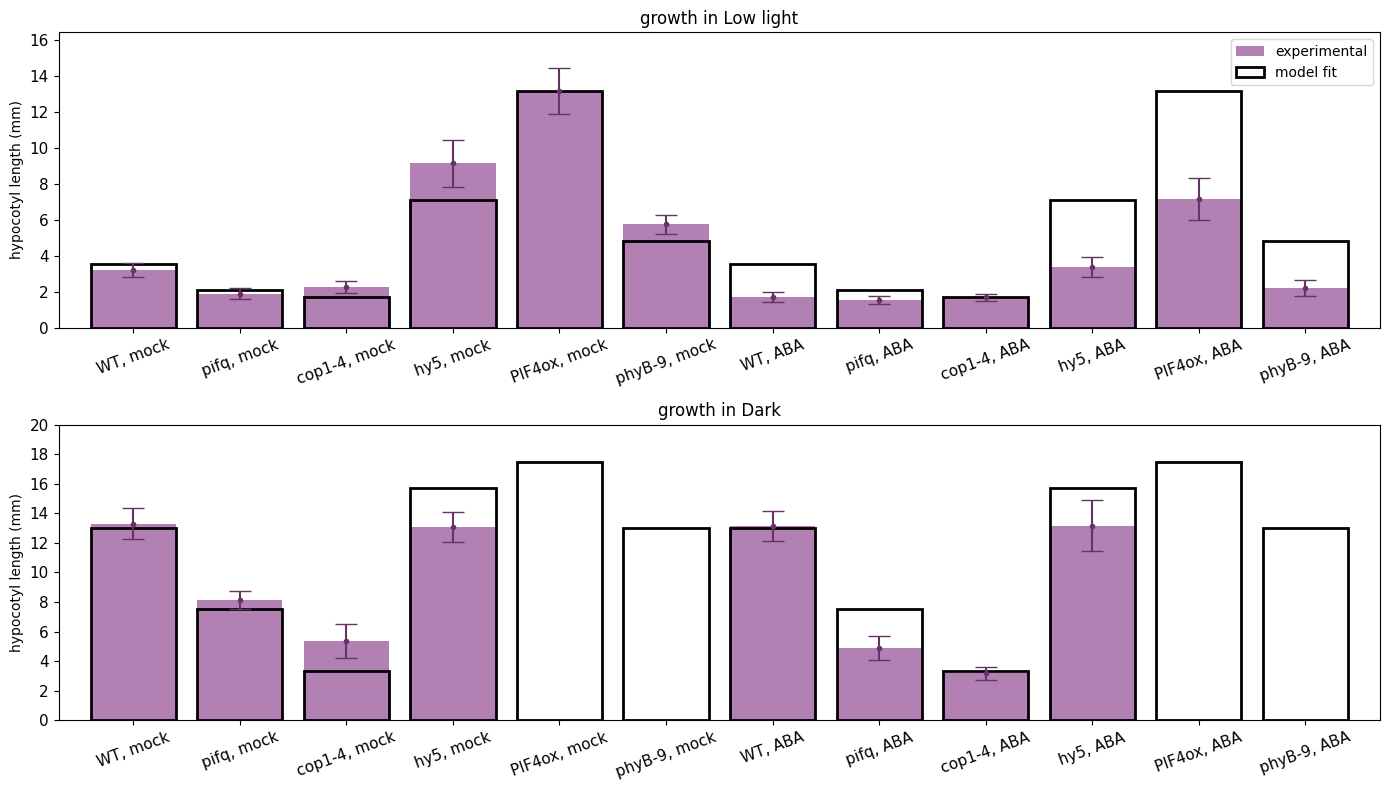


Model (no ABA):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524   3.521134   2.075224     1.709069   7.087172   
Dark          12.983802  12.983802   7.549275     3.333410  15.715980   

           PIF4ox, ABA  phyB-9, ABA  
Low light    13.137210     4.787524  
Dark         17.465473    12.983802  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.

In [6]:
# =========================
# Main: just compute differences
# =========================

common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

if __name__ == "__main__":

    T_fit = 22

    # Model predictions with calibrated base (no-ABA) model 
    ## IMPORTANT -> By don't changing any "None" value of p_PA, p_BA or p_CA
    results_fit = compute_results(T=T_fit)

    # Differences
    diff = results_fit - results_exp

    # Weighted SSE using stdv_exp
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)
    SSE = np.nansum(diff**2)
    wSSE = float(np.sum(((results_fit - results_exp)[mask] / stdv_exp[mask])**2))
    N = int(np.sum(mask))
    RMSE = np.sqrt(SSE / N) if N > 0 else np.nan

    # Print Results
    print(f"Base model without ABA:")
    print(f"  SSE (unweighted)   = {SSE:.6g}")
    print(f"  weighted SSE       = {wSSE:.6g}")
    print(f"  RMSE (unweighted)  = {RMSE:.6g} over N={N} points")

    plot_bars_full(results_exp, stdv_exp, results_fit)

    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (no ABA):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.1. Only fitting p_PA

Optimization terminated successfully.
         Current function value: 75.053454
         Iterations: 12
         Function evaluations: 25

Optimized: p_BA = 6.94075
Final weighted SSE = 75.0535


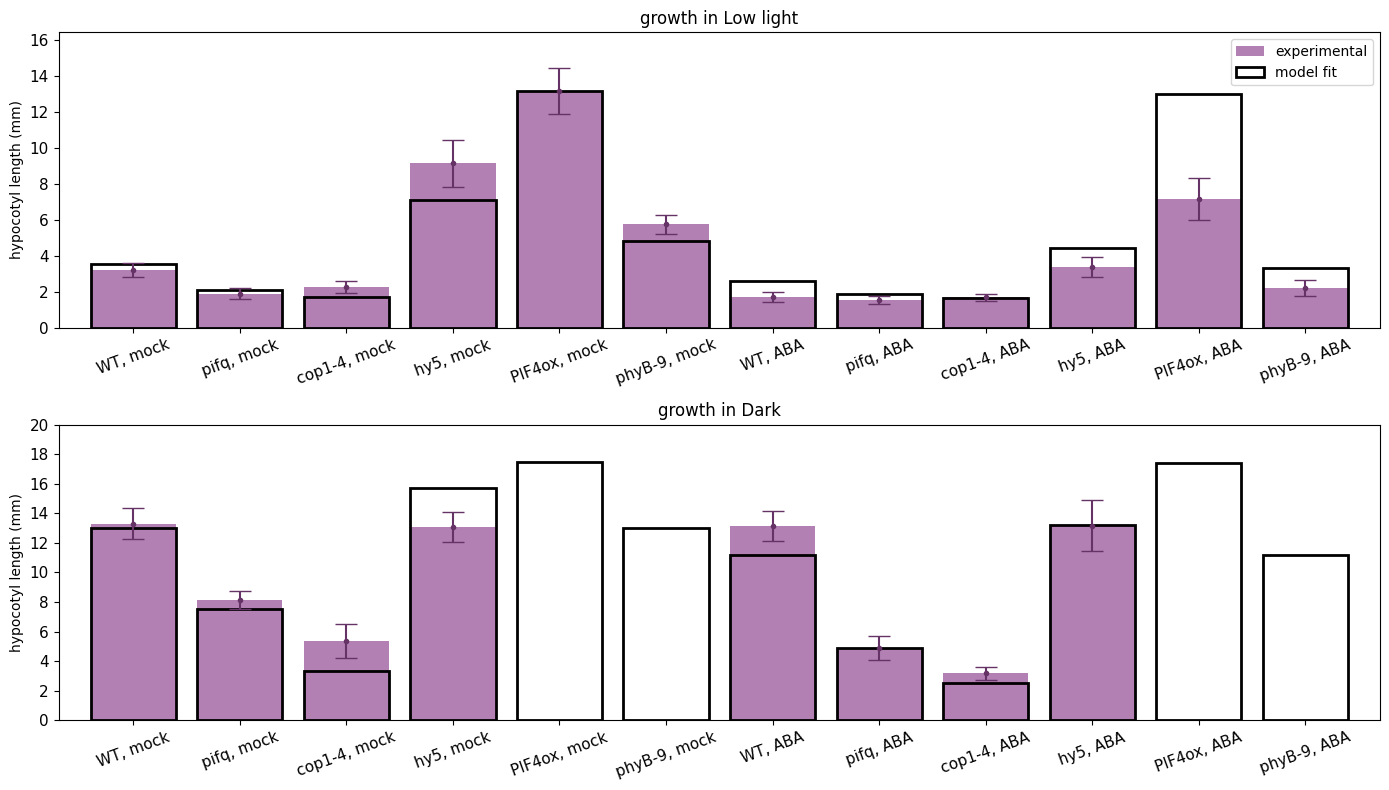


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524   2.604428   1.854513     1.671187   4.426690   
Dark          12.983802  11.154249   4.875795     2.504950  13.208332   

           PIF4ox, ABA  phyB-9, ABA  
Low light    13.011525     3.299400  
Dark         17.423703    11.154249  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.

In [7]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameter:
      p_PA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameter/s
        (log_p_PA,) = theta
        p_PA = np.exp(log_p_PA)

        vec = np.array([p_PA], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_PA=p_PA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_PA only
# =========================
if __name__ == "__main__":

    T_fit = 22
    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guess: p_PA ~ 10
    theta0 = [np.log(10.0)]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=200, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    (log_p_PA_opt,) = res.x
    p_PA_opt = np.exp(log_p_PA_opt)

    # Print results
    print(f"\nOptimized: p_BA = {p_PA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_PA=p_PA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.2. Only fitting phyB

Optimization terminated successfully.
         Current function value: 83.810141
         Iterations: 15
         Function evaluations: 35

Optimized: p_BA = 112.202
Final weighted SSE = 83.8101


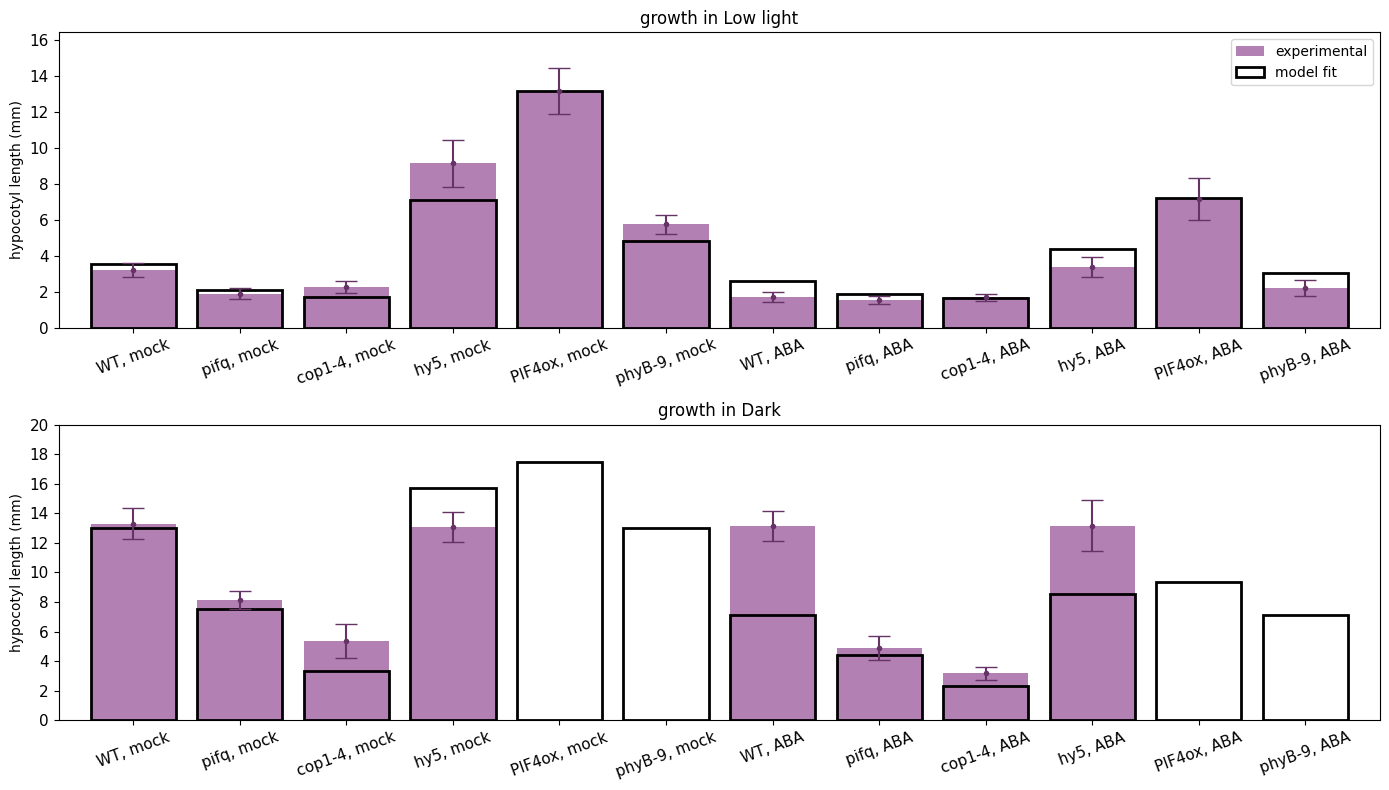


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock   WT, ABA  pifq, ABA  cop1-4, ABA  hy5, ABA  \
Low light      4.787524  2.577223   1.854249     1.671178  4.360286   
Dark          12.983802  7.145234   4.427948     2.320019  8.511182   

           PIF4ox, ABA  phyB-9, ABA  
Low light     7.222224     3.047398  
Dark          9.386050     7.145234  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.142778

In [8]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameter:
      p_CA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameter/s
        (log_p_BA,) = theta
        p_BA = np.exp(log_p_BA)

        vec = np.array([p_BA], dtype=float)

        # Avoid extreme values by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_BA=p_BA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_BA only
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guess: p_BA ~ 10
    theta0 = [np.log(10.0),]

    res = minimize(objective, theta0,method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=200, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    (log_p_BA_opt,) = res.x
    p_BA_opt = np.exp(log_p_BA_opt)

    # Print Results
    print(f"\nOptimized: p_BA = {p_BA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_BA=p_BA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 2.3. Only fitting COP1

Optimization terminated successfully.
         Current function value: 75.411768
         Iterations: 19
         Function evaluations: 42

Optimized: p_CA = 67.015
Final weighted SSE = 75.4118


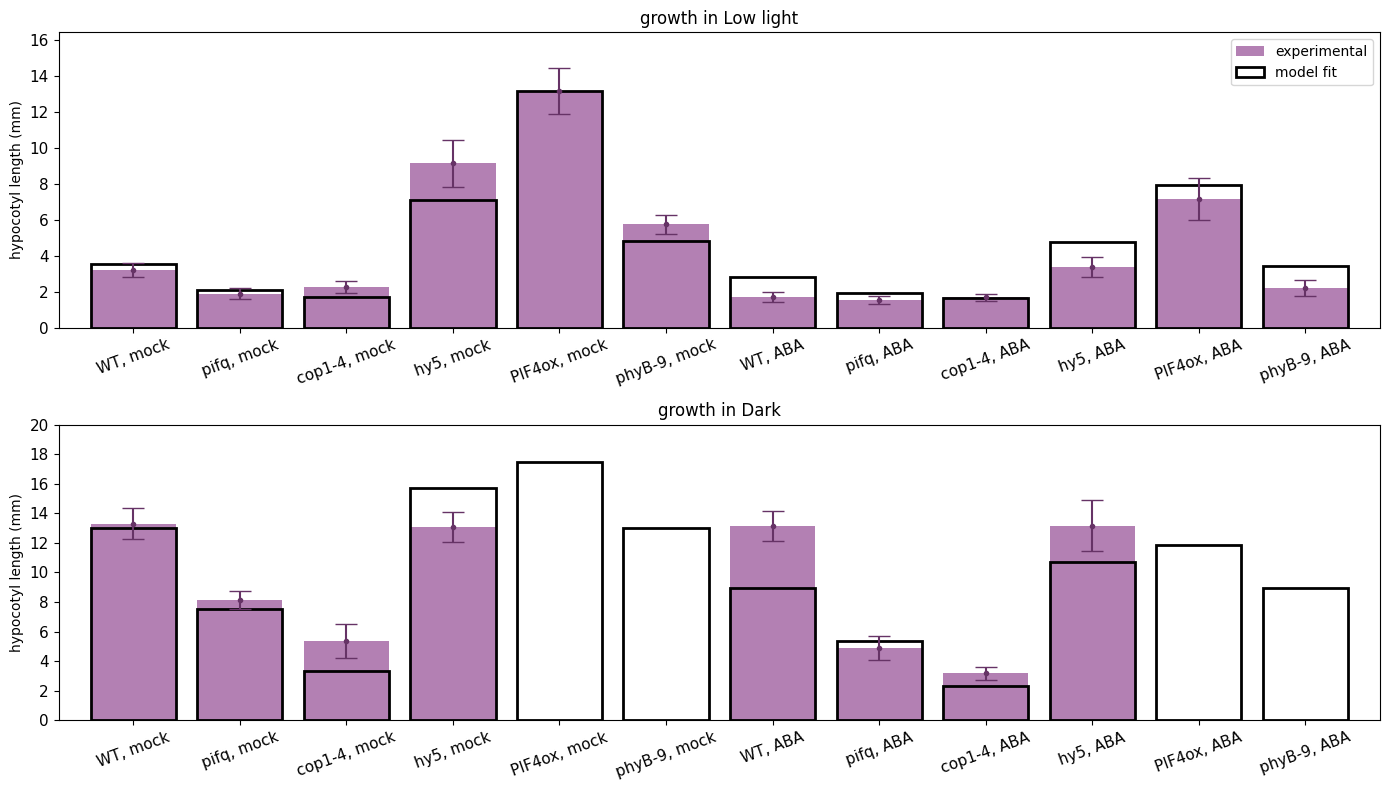


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock   WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524  2.785640   1.905019     1.671176   4.733897   
Dark          12.983802  8.916896   5.375302     2.320471  10.695671   

           PIF4ox, ABA  phyB-9, ABA  
Low light     7.950557     3.403646  
Dark         11.827293     8.916896  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.142

In [9]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameter:
      p_CA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore GLOBAL state
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameter
        (log_p_CA,) = theta
        p_CA = np.exp(log_p_CA)

        vec = np.array([p_CA], dtype=float)

        # Avoid extreme values by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_CA=p_CA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_CA only
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guess: p_CA ~ 10
    theta0 = [np.log(10.0),]

    res = minimize(objective, theta0,method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=300, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    (log_p_CA_opt,) = res.x
    p_CA_opt = np.exp(log_p_CA_opt)

    # Print results
    print(f"\nOptimized: p_CA = {p_CA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_CA=p_CA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

# 3. Fitting combinations

## 3.1. Fitting p_PA + p_BA

Optimization terminated successfully.
         Current function value: 76.580424
         Iterations: 109
         Function evaluations: 272

Optimized: p_PA = 7.21347, p_BA = 199.785
Final weighted SSE = 76.5804


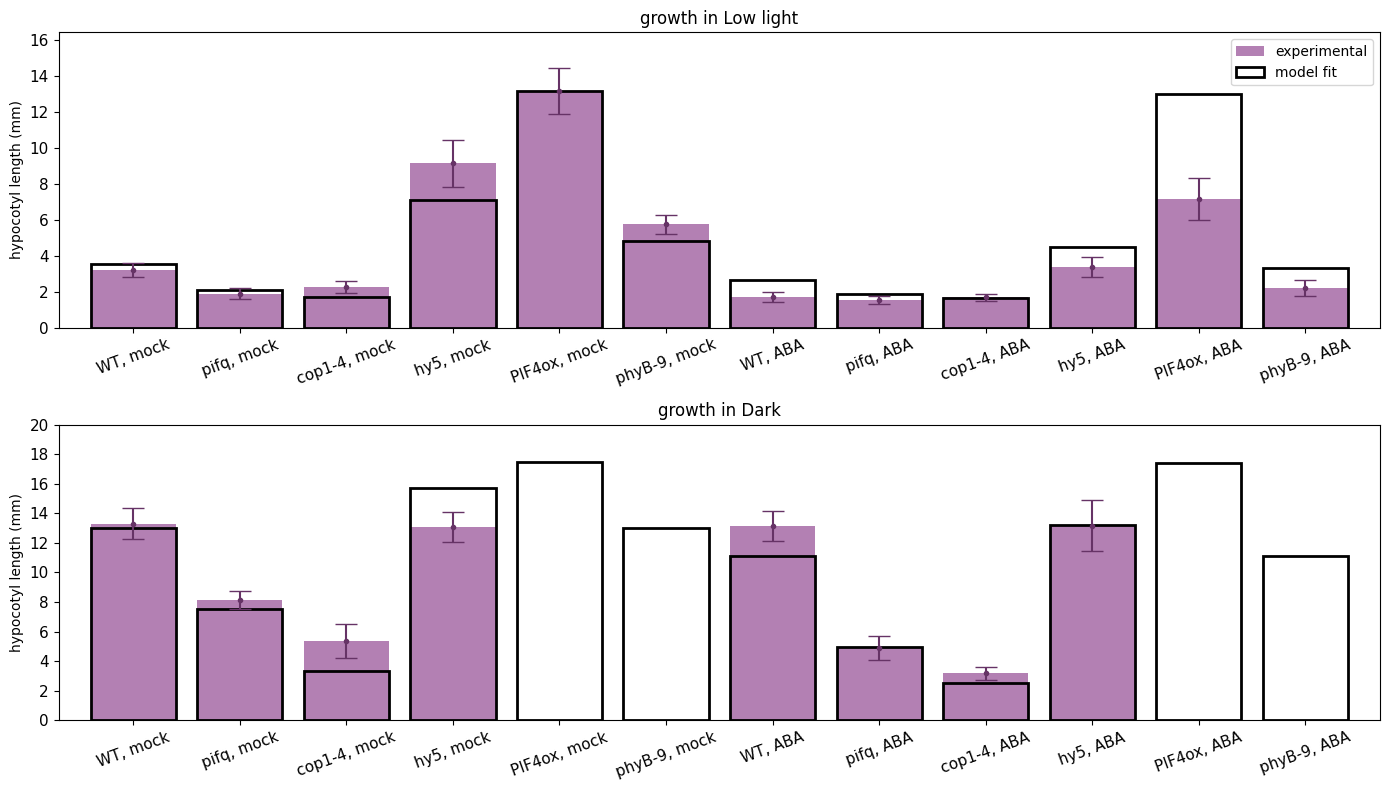


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524   2.632456   1.862217     1.671186   4.475693   
Dark          12.983802  11.126121   4.959224     2.493748  13.185594   

           PIF4ox, ABA  phyB-9, ABA  
Low light    13.002558     3.324505  
Dark         17.422051    11.126121  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.

In [10]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      p_PA, p_BA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore GLOBAL state
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameters
        log_p_PA, log_p_BA = theta
        p_PA = np.exp(log_p_PA)
        p_BA = np.exp(log_p_BA)

        vec = np.array([p_PA, p_BA], dtype=float)

        # Avoid extreme values
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_PA=p_PA, p_CA=p_BA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_PA + p_BA
# =========================
if __name__ == "__main__":

    T_fit = 22
    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: p_PA ~ 10, p_CA ~ 10
    theta0 = [np.log(10.0), np.log(10.0),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=400, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_p_PA_opt, log_p_BA_opt = res.x
    p_PA_opt = np.exp(log_p_PA_opt)
    p_BA_opt = np.exp(log_p_BA_opt)

    # Print results
    print(f"\nOptimized: p_PA = {p_PA_opt:.6g}, p_BA = {p_BA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_PA=p_PA_opt, p_BA=p_BA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 3.2. Fitting p_PA + p_CA

Optimization terminated successfully.
         Current function value: 76.580424
         Iterations: 109
         Function evaluations: 272

Optimized: p_PA = 7.21347, p_CA = 199.785
Final weighted SSE = 76.5804


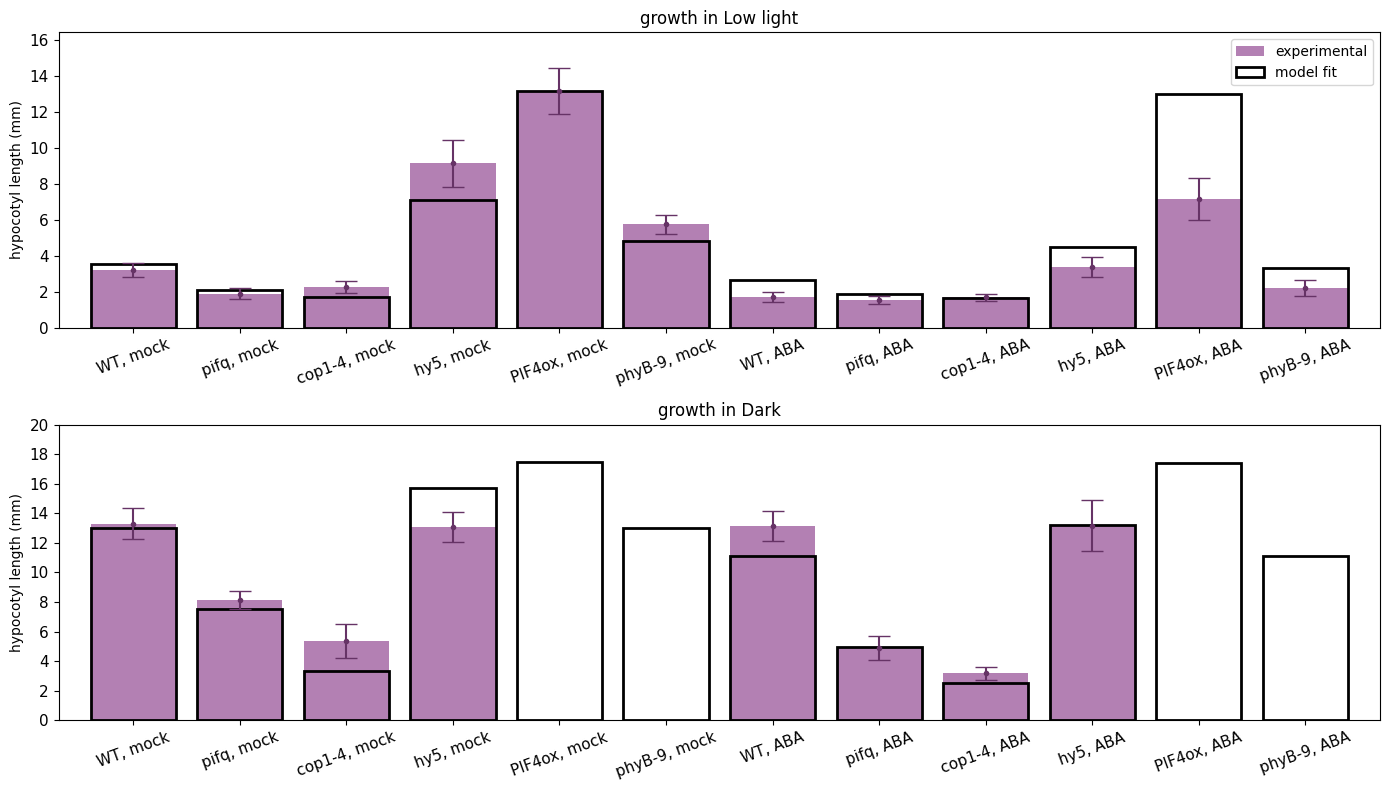


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524   2.632434   1.862221     1.671186   4.475610   
Dark          12.983802  11.126121   4.959224     2.493748  13.185594   

           PIF4ox, ABA  phyB-9, ABA  
Low light    13.001960     3.324505  
Dark         17.422051    11.126121  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.

In [11]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      p_PA, p_CA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameters/s
        log_p_PA, log_p_CA = theta
        p_PA = np.exp(log_p_PA)
        p_CA = np.exp(log_p_CA)

        vec = np.array([p_PA, p_CA], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_PA=p_PA, p_CA=p_CA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_PA + p_CA
# =========================
if __name__ == "__main__":

    T_fit = 22
    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: p_PA ~ 10, p_CA ~ 10
    theta0 = [np.log(10.0), np.log(10.0),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=400, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_p_PA_opt, log_p_CA_opt = res.x
    p_PA_opt = np.exp(log_p_PA_opt)
    p_CA_opt = np.exp(log_p_CA_opt)

    # Print results
    print(f"\nOptimized: p_PA = {p_PA_opt:.6g}, p_CA = {p_CA_opt:.6g}"
    )
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_PA=p_PA_opt, p_CA=p_CA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 3.3. Fitting p_BA + p_CA

Optimization terminated successfully.
         Current function value: 75.411933
         Iterations: 48
         Function evaluations: 109

Optimized: p_PA = 66.9602, p_CA = 199.785
Final weighted SSE = 75.4119


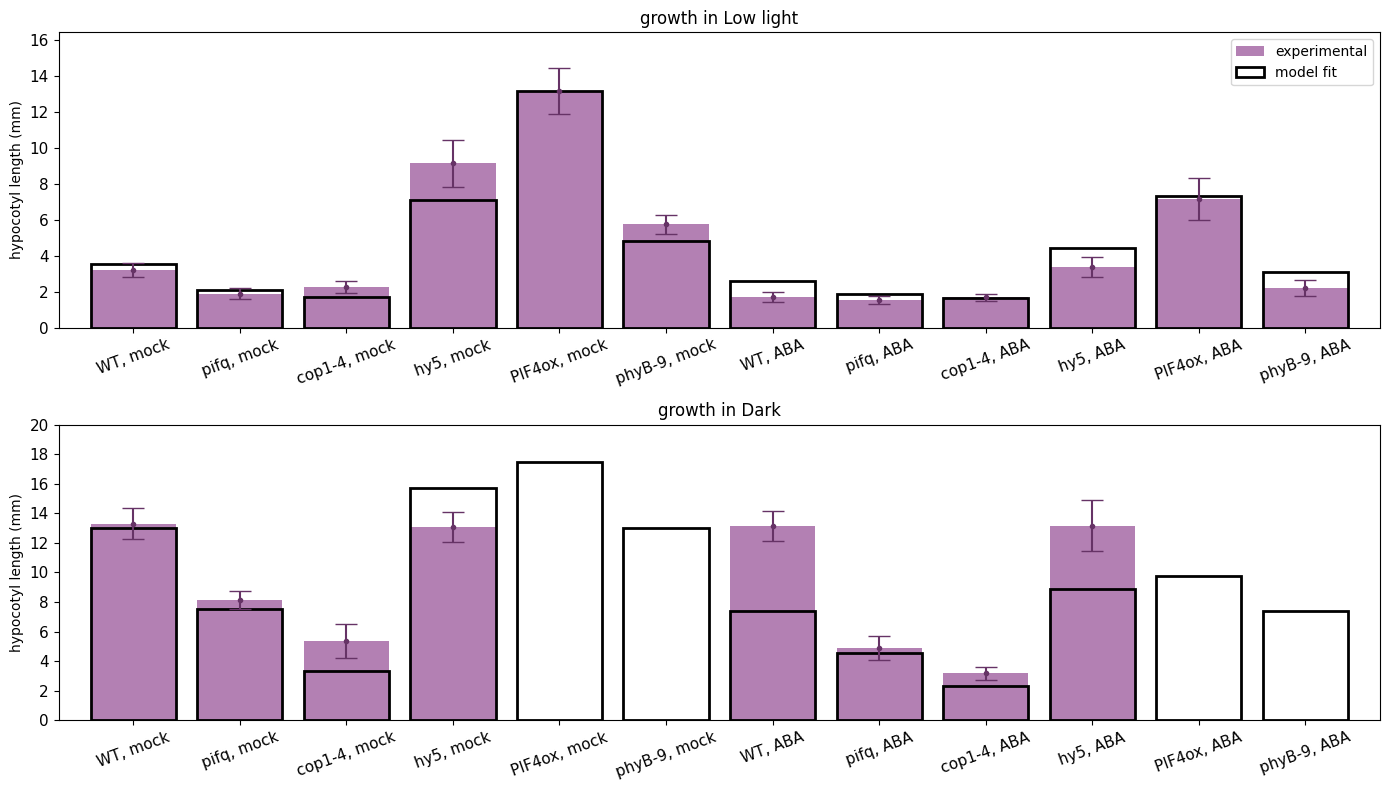


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock   WT, ABA  pifq, ABA  cop1-4, ABA  hy5, ABA  \
Low light      4.787524  2.609003   1.861992     1.671180  4.417337   
Dark          12.983802  7.418033   4.573841     2.320069  8.847502   

           PIF4ox, ABA  phyB-9, ABA  
Low light     7.332671     3.101626  
Dark          9.760370     7.418033  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.142778

In [12]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      p_BA, p_CA (> 0, bounded).
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameter/s
        log_p_BA, log_p_CA = theta
        p_BA = np.exp(log_p_BA)
        p_CA = np.exp(log_p_CA)

        vec = np.array([p_BA, p_CA], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 200.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_BA=p_BA, p_CA=p_CA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den  = stdv_exp[mask]
        resid = diff / den

        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_BA + p_CA
# =========================
if __name__ == "__main__":

    T_fit = 22
    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: p_BA ~ 10, p_CA ~ 10
    theta0 = [np.log(10.0), np.log(10.0),]

    res = minimize(objective, theta0, method="Nelder-Mead",
        options=dict(xatol=1e-3, fatol=1e-3, maxiter=400, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_p_BA_opt, log_p_BA_opt = res.x
    p_BA_opt = np.exp(log_p_BA_opt)
    p_CA_opt = np.exp(log_p_CA_opt)

    print(f"\nOptimized: p_PA = {p_BA_opt:.6g}, p_CA = {p_CA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_BA=p_BA_opt, p_CA=p_CA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)

## 3.4. Fitting p_PA + p_BA + p_CA

Optimization terminated successfully.
         Current function value: 75.738979
         Iterations: 107
         Function evaluations: 218

Optimized: p_PA = 7.11226, p_BA = 245.001, p_CA = 299.497
Final weighted SSE = 75.739


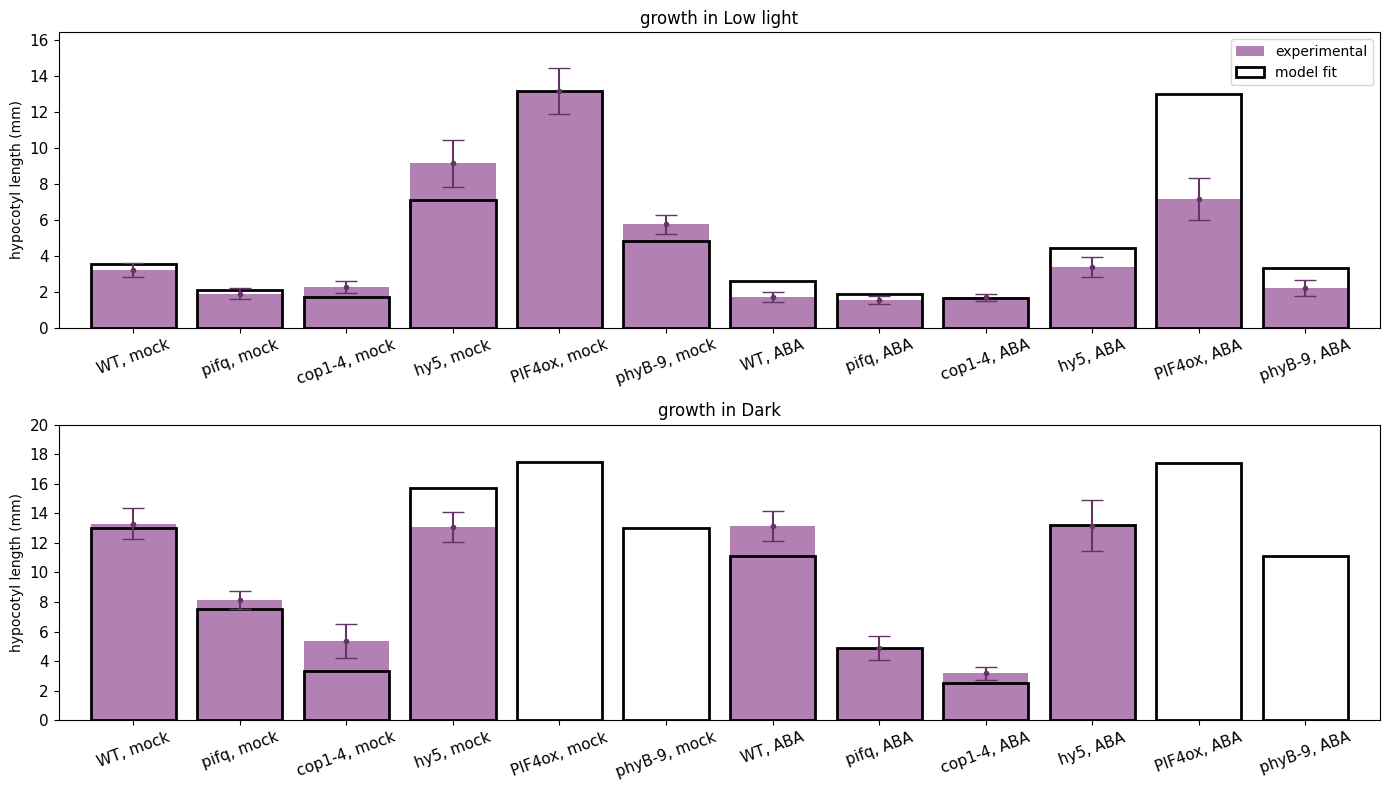


Model (fitted):
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.521134    2.075224      1.709069   7.087172     13.137210   
Dark       12.983802    7.549275      3.333410  15.715980     17.465473   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      4.787524   2.616821   1.858020     1.671186   4.448099   
Dark          12.983802  11.128270   4.908432     2.497785  13.181581   

           PIF4ox, ABA  phyB-9, ABA  
Low light    13.005919     3.307674  
Dark         17.422629    11.128270  

Experimental means:
             WT, mock  pifq, mock  cop1-4, mock  hy5, mock  PIF4ox, mock  \
Low light   3.203250    1.889167      2.236700     9.1349     13.129625   
Dark       13.296875    8.119231      5.374286    13.0900           NaN   

           phyB-9, mock    WT, ABA  pifq, ABA  cop1-4, ABA   hy5, ABA  \
Low light      5.752222   1.691778   1.537667     1.680652   3.368520   
Dark                NaN  13.

In [13]:
# =========================
# Robust objective function
# =========================
def make_objective(results_exp, stdv_exp, T_fit=22, penalty=1e12):
    """
    Build robust objective for parameters:
      p_PA, p_BA, p_CA (> 0, bounded) and fitted in shifted log-space
    """
    mask = np.isfinite(results_exp) & np.isfinite(stdv_exp) & (stdv_exp > 0)

    def objective(theta):
        # Restore (Parameters) Global State
        common_params.clear(); common_params.update(BASE_COMMON_PARAMS)

        # Apply the adjustment parameter/s
        log_p_PA, log_p_BA, log_p_CA = theta
        p_PA = np.exp(log_p_PA)
        p_BA = np.exp(log_p_BA)
        p_CA = np.exp(log_p_CA)

        vec = np.array([p_PA, p_BA, p_CA], dtype=float)

        # Avoid extrem value regimes by setting bounds 
        if not np.all(np.isfinite(vec)):
            return penalty
        if np.any(vec < 1e-3) or np.any(vec > 300.0):
            return penalty

        try:
            model = compute_results(T=T_fit, p_PA=p_PA, p_BA=p_BA, p_CA=p_CA)
        except Exception:
            return penalty

        if not np.all(np.isfinite(model)):
            return penalty

        diff = (model - results_exp)[mask]
        den = stdv_exp[mask]
        resid = diff / den
        return float(np.sum(resid * resid))

    return objective


# =========================
# Main: fit p_PA, p_BA, p_CA
# =========================
if __name__ == "__main__":

    T_fit = 22

    objective = make_objective(results_exp, stdv_exp, T_fit=T_fit)

    # initial guesses: p_* ~ 15 (shifted log-space)
    theta0 = [np.log(15.0), np.log(15.0), np.log(15.0),]

    res = minimize(objective,theta0,method="Nelder-Mead",
                   options=dict(xatol=1e-3, fatol=1e-3, maxiter=400, disp=True))

    if not res.success:
        print("WARNING optimizer:", res.message)

    log_p_PA_opt, log_p_BA_opt, log_p_CA_opt = res.x
    p_PA_opt = np.exp(log_p_PA_opt)
    p_BA_opt = np.exp(log_p_BA_opt)
    p_CA_opt = np.exp(log_p_CA_opt)

    # Print results
    print(f"\nOptimized: p_PA = {p_PA_opt:.6g}, p_BA = {p_BA_opt:.6g}, p_CA = {p_CA_opt:.6g}")
    print(f"Final weighted SSE = {res.fun:.6g}")

    results_fit = compute_results(T=T_fit, p_PA=p_PA_opt, p_BA=p_BA_opt, p_CA=p_CA_opt)
    plot_bars_full(results_exp, stdv_exp, results_fit)
    
    # Tabular printout 
    try:
        rows = ["Low light", "Dark"]
        cols = [
            "WT, mock", "pifq, mock", "cop1-4, mock", "hy5, mock", "PIF4ox, mock", "phyB-9, mock",
            "WT, ABA",  "pifq, ABA",  "cop1-4, ABA",  "hy5, ABA",  "PIF4ox, ABA",  "phyB-9, ABA",
        ]
        print("\nModel (fitted):\n",
              pd.DataFrame(results_fit, index=rows, columns=cols))
        
        print("\nExperimental means:\n",
              pd.DataFrame(results_exp, index=rows, columns=cols))
        
        print("\nDifference (model - exp):\n",
              pd.DataFrame(diff, index=rows, columns=cols))
        
    except Exception as e:
        print("Table print failed:", e)